In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from flytrailvr.utils import extract_data,process_important_variables,plot_trajectory,config_to_title

# generate linear color map from two colors in matplotlib
from matplotlib.colors import LinearSegmentedColormap

pkw = LinearSegmentedColormap.from_list('pkor', ['white', 'crimson'], N=256)
pkor = LinearSegmentedColormap.from_list('pkor', ['pink', 'crimson'], N=256)
blnv = LinearSegmentedColormap.from_list('blnv', ['lightskyblue', 'royalblue'], N=256)
    

In [6]:
# data folder
data_folder = '../data/charlie_rig_rishika/'

In [7]:
data = list(filter(lambda x: os.path.isdir(os.path.join(data_folder, x)), os.listdir(data_folder)))
dates = [pd.to_datetime(x.split('_')[-1], format='%Y%m%d-%H%M%S') for x in data]
# sort by date
data = [x for _, x in sorted(zip(dates, data))]
for d in data:
    print(d)

low_wind_wide_20240319-141201
low_wind_thin_20240319-150617
orco_thinstrip_with_odor_20240320-164441
orco_thinstrip_test_20240320-173646
orco_thinstrip_test_20240320-173843
orco_thinstrip_test_20240320-174642
orco_thinstrip_20240321-112203
orco_thinstrip_20240321-112442
orco_thinstrip_low_wind_20240321-114717
orco_thinstrip__no_wind_visual_20240321-121715
orco_thinstrip_low_wind_20240321-150513
orco_thinstrip_low_wind_20240321-151534
orco_alternated_wind_20240321-153548
orco_alternated_wind_48hr_20240322-105843
orco_thinstrip_lowwind_20240322-114228
orco_alternated_wind_20240322-131005
orco_alternated_wind_20240326-105020
orco_alternated_wind_continued_20240326-110233
orco_alternated_wind_20240326-120252
orco_thinstrip_20240326-125708
orco_alternated_wind_20240326-143951
orco_alternated_wind_continued_20240326-144619
odor_alternated_wind_20240402-104116
odor_alternated_wind_20240402-111329
odor_alternated_wind_20240402-123659


In [4]:
file = 'low_wind_wide_20240319-141201'
y_range = [1500, 2000]

/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


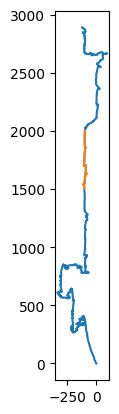

In [43]:
df, config, logic, comments = extract_data("../data/charlie_rig_rishika/" + file + "/")
min_odor = df['mfc2_stpt'].min()
max_odor = df['mfc2_stpt'].max()
plt.plot(df['ft_posx'], df['ft_posy'])
plt.gca().set_aspect('equal', adjustable='box')
# keep only the df when posy is between 1000 and 2000
df = df[(df['ft_posy'] > y_range[0]) & (df['ft_posy'] < y_range[1])].reset_index(drop=True)
plt.plot(df['ft_posx'], df['ft_posy'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [44]:
# find odor boundaries
odor_on = df['mfc2_stpt']
odor_on = (odor_on - min_odor) / (max_odor - min_odor)
odor_on = odor_on > 0.5
odor_regions = df[odor_on].reset_index(drop=True)
# minimum x and maximum x
min_x = odor_regions['ft_posx'].min()
max_x = odor_regions['ft_posx'].max()
print(min_x, max_x)

-105.16889126183251 -95.22856716606064


In [45]:
time = df['timestamp']-df['timestamp'].iloc[0]
time = time.dt.total_seconds()
frame_rate = 1/np.mean(np.diff(time))
frames = len(df)
past_window = 15 # seconds
scale_factor = 256/20 # 1 cm = 256 pixels

In [50]:
!poetry add imageio

Using version ^2.34.1 for imageio

Updating dependencies
Resolving dependencies... (3.1s)Resolving dependencies... (0.2s)Resolving dependencies... (0.3s)Resolving dependencies... (2.8s)

Package operations: 1 install, 0 updates, 0 removals

  • Installing imageio (2.34.1): Pending...
  • Installing imageio (2.34.1): Downloading... 0%
  • Installing imageio (2.34.1): Downloading... 100%
  • Installing imageio (2.34.1): Installing...
  • Installing imageio (2.34.1)

Writing lock file


In [52]:
# create a video and gif of the trajectory

import cv2
from tqdm import tqdm

# create an empty image
img = np.zeros((512, 512, 3), np.uint8)
# create a video writer for the trajectory
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('trajectory.mp4', fourcc, 2*frame_rate, (512, 512))

# loop through the frames
for i in tqdm(range(frames)):
    # create a new image (copy of the empty image)
    img = np.zeros((512, 512, 3), np.uint8)
    # get the frames in the past_window
    df_past = df[(time > time[i] - past_window) & (time <= time[i])].reset_index(drop=True)

    # draw odor regions
    start_x = 256 - (min_x - df_past['ft_posx'].iloc[-1]) * scale_factor
    end_x = 256 - (max_x - df_past['ft_posx'].iloc[-1]) * scale_factor
    # draw a rectangle from start_x to end_x through the whole image
    cv2.rectangle(img, (int(start_x), 0), (int(end_x), 512), (0, 0, 63), -1)

    # plot the trajectory
    df_past['ft_posx'] = 256 - (df_past['ft_posx'] - df_past['ft_posx'].iloc[-1]) * scale_factor# + 256
    df_past['ft_posy'] = 256 - (df_past['ft_posy'] - df_past['ft_posy'].iloc[-1]) * scale_factor# + 256
    # get instrip
    instrip = df_past['mfc2_stpt']
    instrip = (instrip - min_odor) / (max_odor - min_odor)
    

    for j in range(len(df_past)-1):
        cv2.line(img, (int(df_past['ft_posx'].iloc[j]), int(df_past['ft_posy'].iloc[j])),
                 (int(df_past['ft_posx'].iloc[j+1]), int(df_past['ft_posy'].iloc[j+1])),
                 (0, 0, 255) if instrip.iloc[j+1] else (255, 255, 255), 2)
        
    # draw the fly as an ellipsoid at the center of the image
    # get heading
    heading = (360-(np.rad2deg(df_past['ft_heading'].iloc[-1])%360)-90)%360
    fly_size = (int(2 * scale_factor), int(1 * scale_factor))
    cv2.ellipse(img, (256, 256), fly_size, heading, 0, 360, (0, 0, 255) if instrip.iloc[-1] else (255, 255, 255), -1)
    # add to the video
    out.write(img)

# release the video
out.release()


100%|██████████| 2219/2219 [00:29<00:00, 75.70it/s]


Processing low_wind_wide_20240319-141201


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


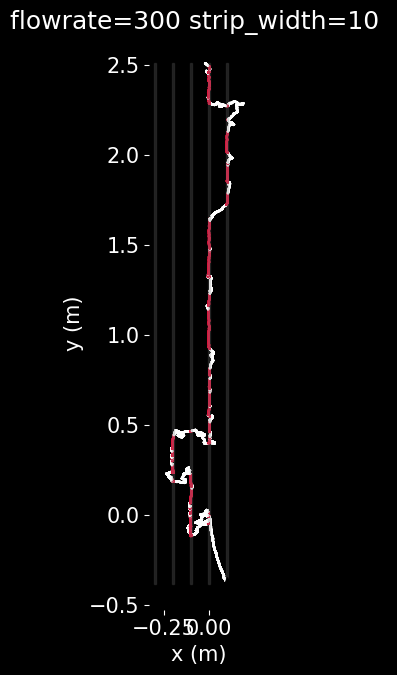

In [12]:
sample_data = 'low_wind_wide_20240319-141201'
print(f'Processing {sample_data}')
save_path = [os.path.join(data_folder, sample_data, 'trajectory.png'),'figures/'+sample_data+'.png']
df, config, logic, comments = extract_data(os.path.join(data_folder, sample_data))
# set font size
plt.rcParams.update({'font.size': 15})
plot_trajectory(df, config, scale_factor=7, show=True, save=save_path, colormaps=[pkw, blnv], odor_or_led='led' if 'orco' in sample_data else 'odor', black_background=True)


Processing low_wind_wide_20240319-141201


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


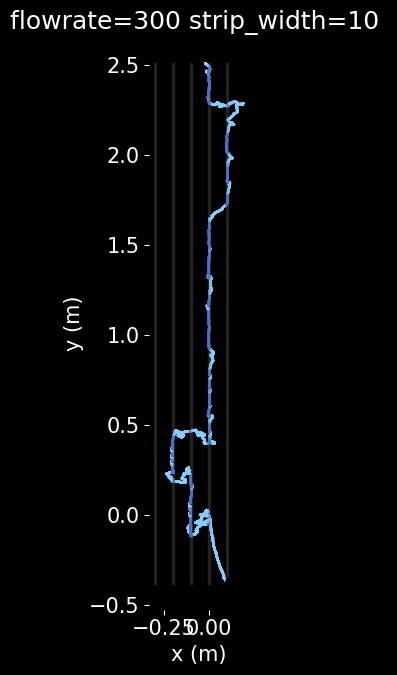

Processing low_wind_thin_20240319-150617


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


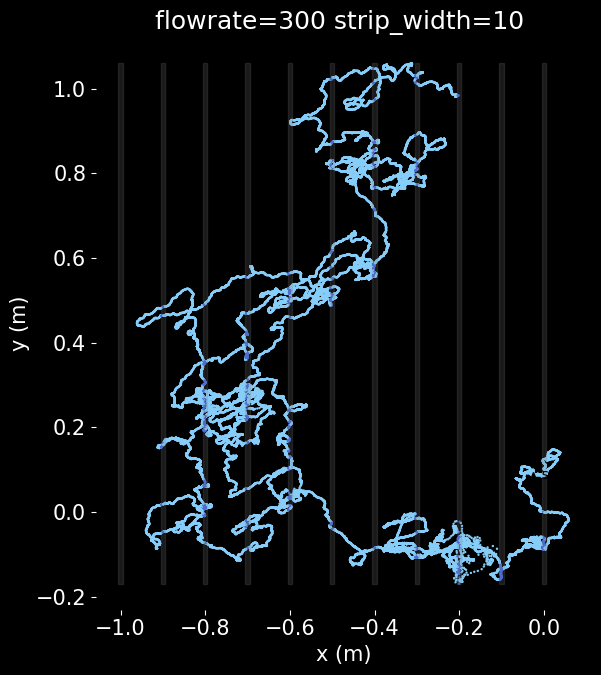

Processing orco_thinstrip_with_odor_20240320-164441


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


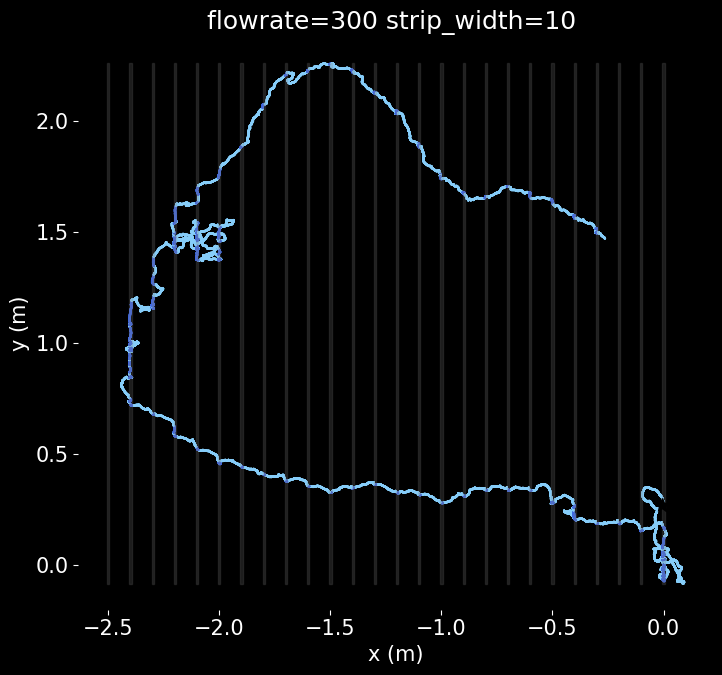

Processing orco_thinstrip_test_20240320-173646
Error in orco_thinstrip_test_20240320-173646: single positional indexer is out-of-bounds
Processing orco_thinstrip_test_20240320-173843


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


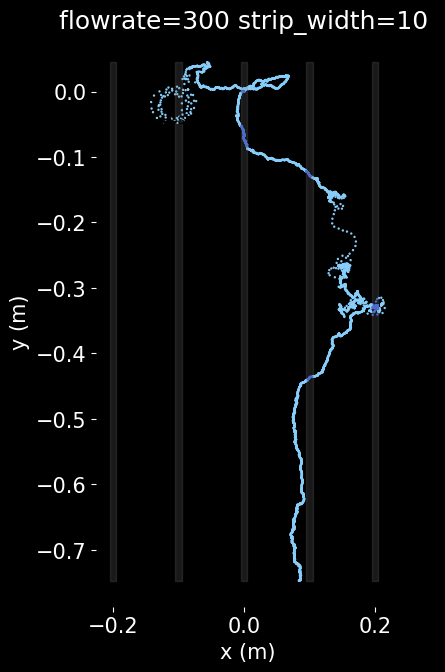

Processing orco_thinstrip_test_20240320-174642


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


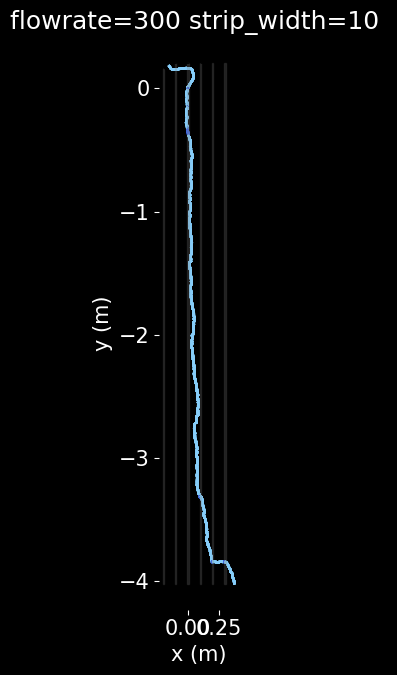

Processing orco_thinstrip_20240321-112203
Error in orco_thinstrip_20240321-112203: single positional indexer is out-of-bounds
Processing orco_thinstrip_20240321-112442


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


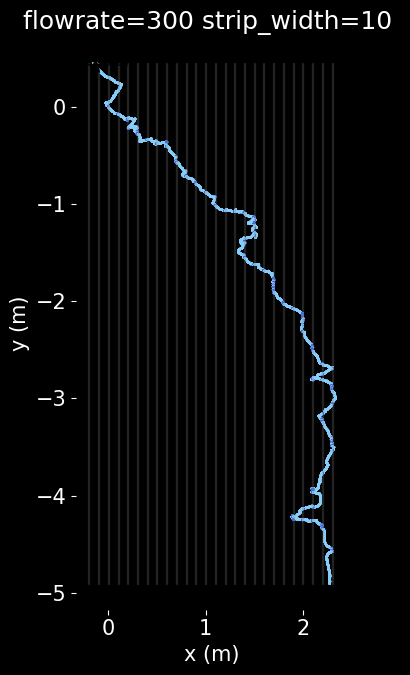

Processing orco_thinstrip_low_wind_20240321-114717


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


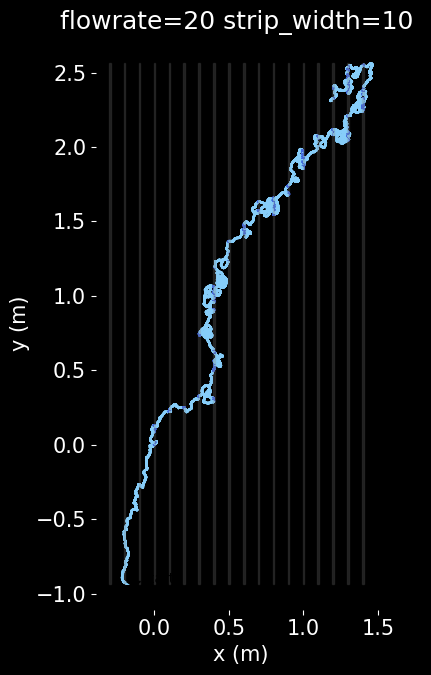

Processing orco_thinstrip__no_wind_visual_20240321-121715


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


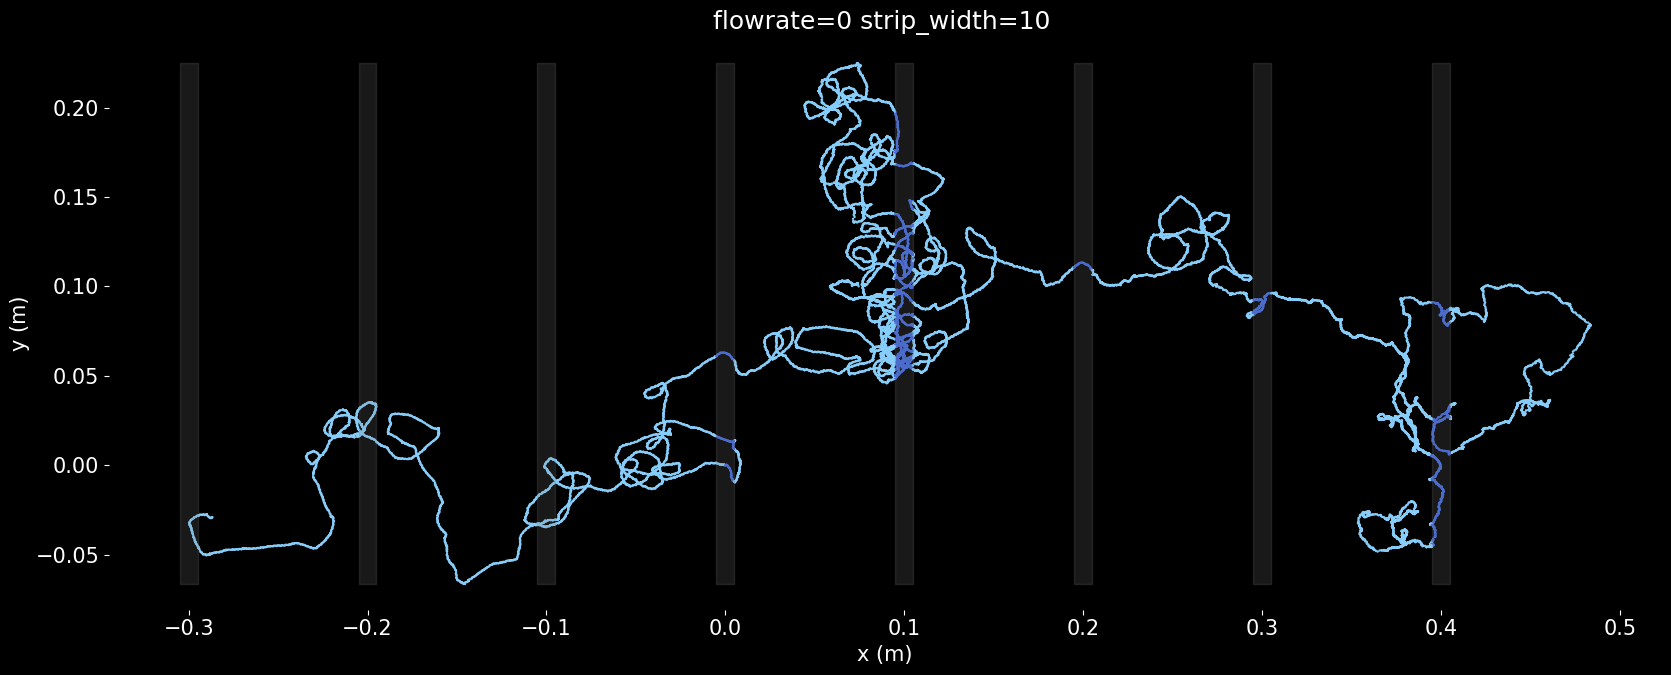

Processing orco_thinstrip_low_wind_20240321-150513


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


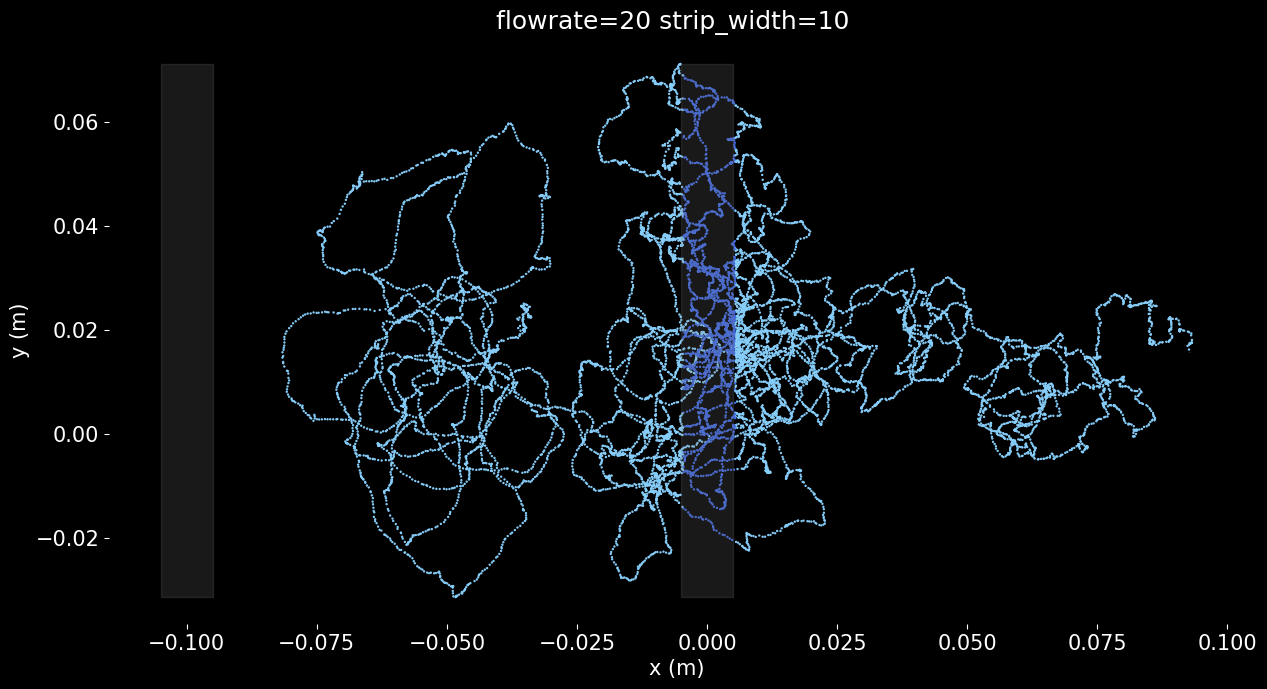

Processing orco_thinstrip_low_wind_20240321-151534


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


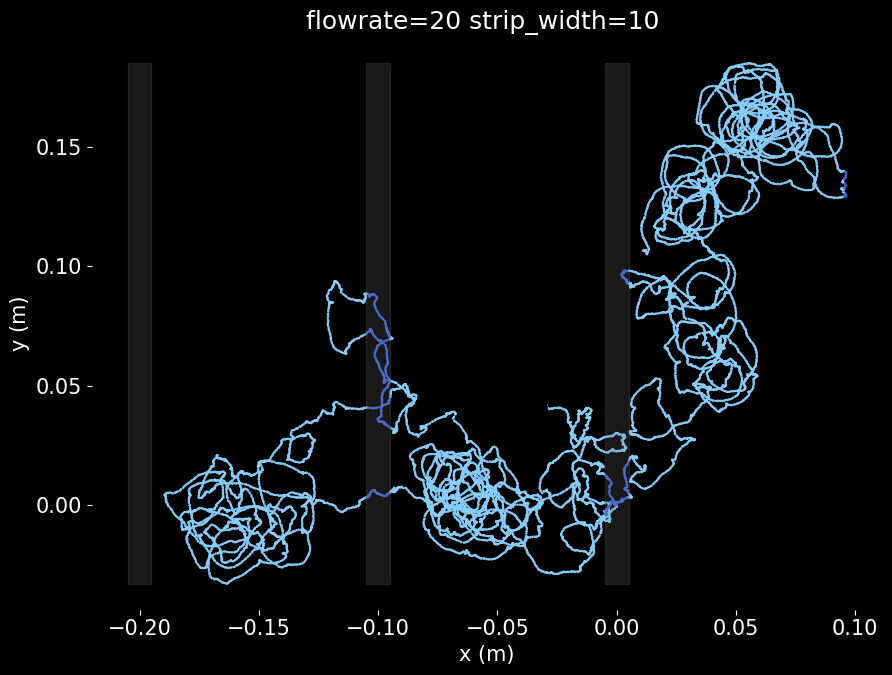

Processing orco_alternated_wind_20240321-153548


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


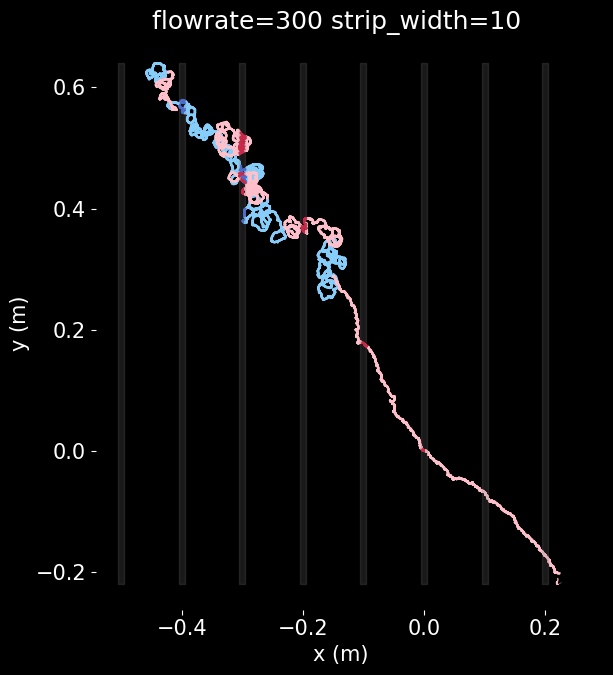

Processing orco_alternated_wind_48hr_20240322-105843


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


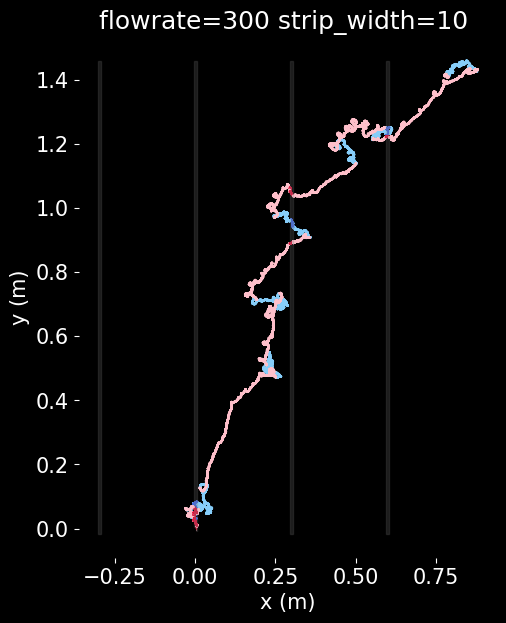

Processing orco_thinstrip_lowwind_20240322-114228


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


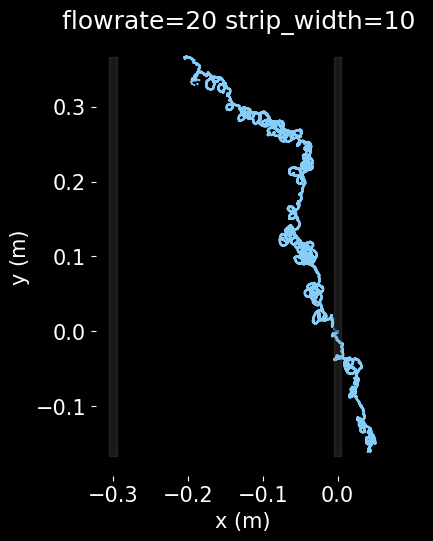

Processing orco_alternated_wind_20240322-131005


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


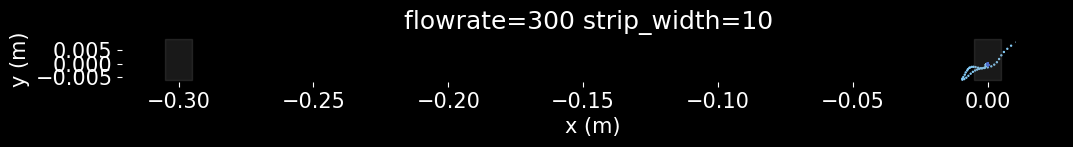

Processing orco_alternated_wind_20240326-105020


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


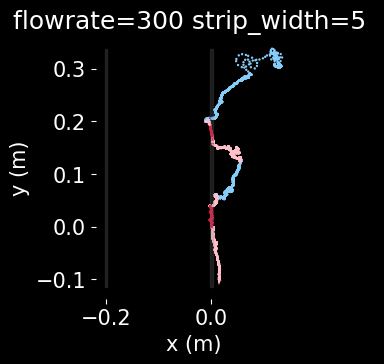

Processing orco_alternated_wind_continued_20240326-110233


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


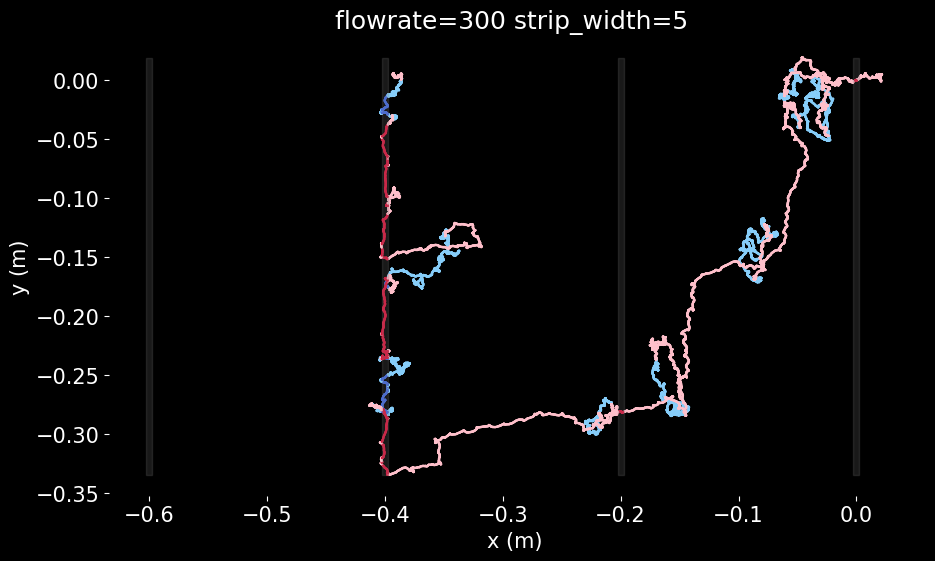

Processing orco_alternated_wind_20240326-120252


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


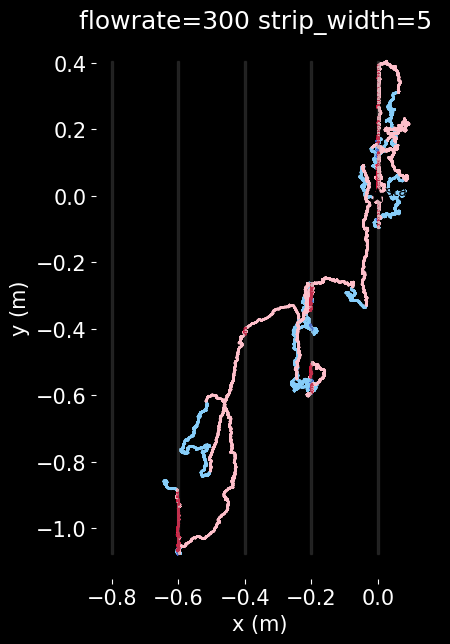

Processing orco_thinstrip_20240326-125708


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


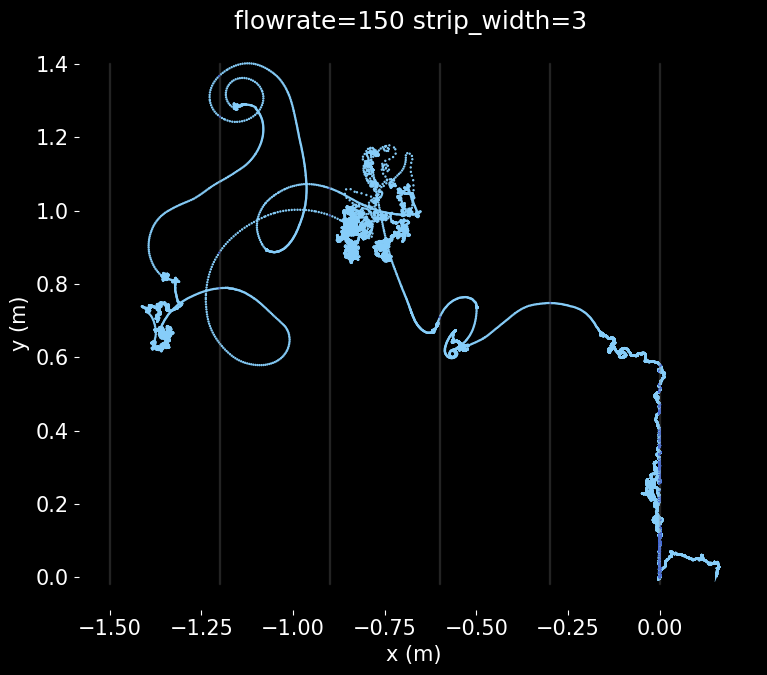

Processing orco_alternated_wind_20240326-143951


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


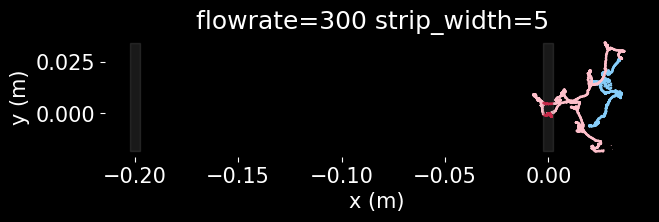

Processing orco_alternated_wind_continued_20240326-144619


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:134: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


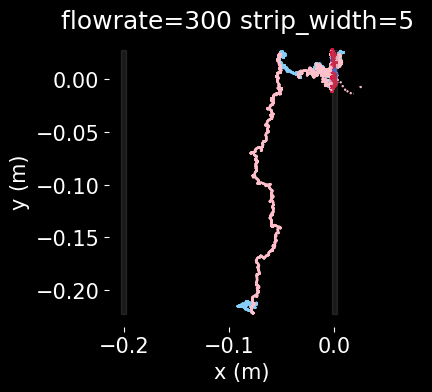

Processing odor_alternated_wind_20240402-104116


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


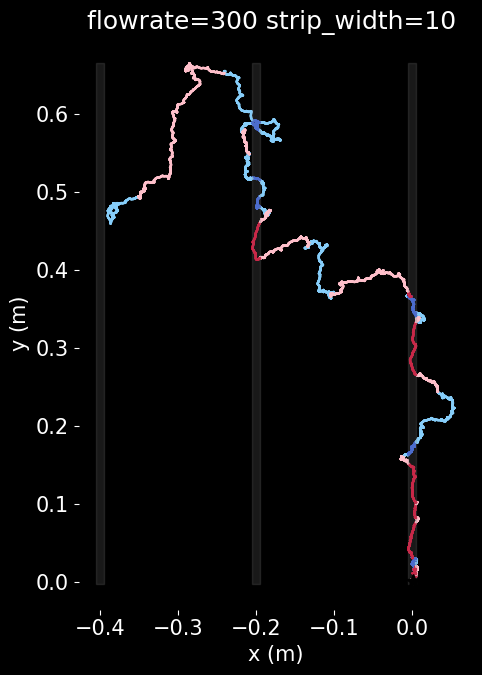

Processing odor_alternated_wind_20240402-111329


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


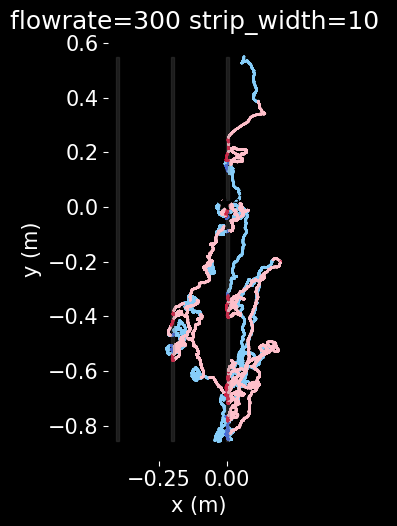

Processing odor_alternated_wind_20240402-123659


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


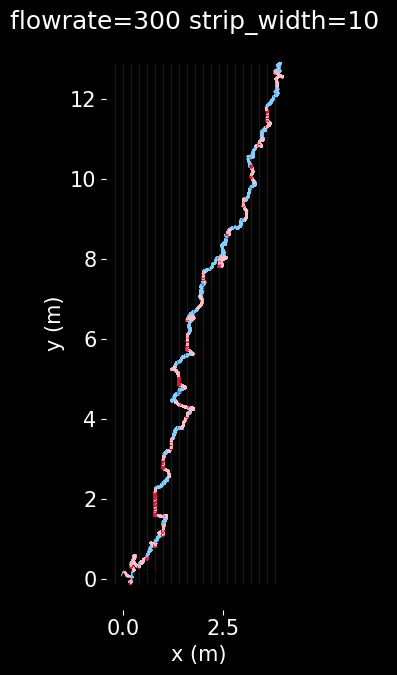

In [14]:
replot = True
for sample_data in data:
    print(f'Processing {sample_data}')
    save_path = [os.path.join(data_folder, sample_data, 'trajectory.png'),'figures/'+sample_data+'.png']
    # check if the figure already exists
    if not replot and all([os.path.exists(x) for x in save_path]):
        # show the existing figure at high resolution
        plt.figure(figsize=(10, 10))
        plt.imshow(plt.imread(save_path[0], format='png'))
        plt.axis('off')
        plt.show()
        continue
    try:
        df, config, logic, comments = extract_data(os.path.join(data_folder, sample_data))
        plot_trajectory(df, config, scale_factor=7, show=True, save=save_path, colormaps=[blnv, pkor], odor_or_led='led' if 'orco' in sample_data else 'odor', black_background=True)
    except Exception as e:
        print(f'Error in {sample_data}: {e}')